# Long-range erosion and deposition models - time evolution

Now we assume that for any of the three models, we integrate through time to determine how the localization pattern progresses.

In [1]:
from quagmire import SurfaceProcessMesh
from quagmire import tools as meshtools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.05, 0.05

x, y, bmask = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, 50000, 1000)
# x, y = meshtools.lloyd_mesh_improvement(x, y, bmask, 5)
DM = meshtools.create_DMPlex_from_points(x, y, bmask)

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0


In [4]:
height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001
height += np.random.random(height.size) * 0.0005 # random noise
rain   = height**2

sp = SurfaceProcessMesh(DM)
sp.update_height(height)
sp.update_surface_processes(rain, np.zeros_like(rain))
sp.verbose=False

 - Delaunay triangulation 0.728396s
 - cKDTree 0.011902s
 - Calculate node weights and area 0.694211s
 - Compute edge lengths 0.071115s
 - Construct nearest neighbour array 0.326524s
 - Find boundaries 0.009603s
 - Build smoothing matrix 0.019095s
 - Construct neighbour cloud array 0.19051s
 - Construct rbf weights 0.068059s
 - Sort nodes by field 0.091624s
 - Build downhill matrices 0.140577s
 - Upstream area 0.068408s


Each of the erosion-depositon models require the stream power...

In [5]:
def compute_stream_power(self, m=1, n=1, critical_slope=None):
    """
    Stream power law (q_s)
    """
    
    if critical_slope != None:
        slope = np.maximum(self.slope, critical_slope)
    else:
        slope = self.slope
    
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall, use3path=True)
    cumulative_flow_rate = cumulative_rain # / self.area
    stream_power = cumulative_flow_rate**m * slope**n
    
    return stream_power

stream_power = compute_stream_power(sp, m=1, n=1)


## 1. Local equilibrium

The assumption of the stream power law is that sediment transport is in a state of local equilibrium in which the transport rate is (less than or) equal to the local carrying capacity. If we neglect suspended-load transport for a moment and assume only bed-load transport then the local deposition is the amount of material that can be eroded from upstream.

In [12]:
def erosion_deposition_1(mesh, stream_power, efficiency=0.1, critical_slope=1000.0):
    """
    Local equilibrium model
    """
    
    erosion_rate = efficiency*stream_power
    full_capacity_sediment_load = stream_power
                                  # Could / should be a more complicated function than this !
         
    # Total sediment load coming from upstream 
    cumulative_eroded_material = mesh.cumulative_flow(erosion_rate*mesh.area) 
        
    # We might need to iterate this for landscapes which steepen after shallowing

    erosion_rate[np.where(cumulative_eroded_material > full_capacity_sediment_load)] = 0.0
    cumulative_eroded_material = mesh.cumulative_flow(erosion_rate*mesh.area) 

    # Local equilibrium assumes all this material is dumped on the spot   
    deposition_rate = np.maximum(0.0,(cumulative_eroded_material - full_capacity_sediment_load)) / mesh.area 
        
    # However, for stability purposes, it is useful to smooth this within the stream bed
    # (The saltation length model can smooth this over a specific length / time downstream)
    
    erosion_rate[~mesh.bmask] = 0.0
    deposition_rate[~mesh.bmask] = 0.0

    # Fix any negative values in the deposition. 
    
    depo_sum = deposition_rate.sum()
    deposition_rate = np.clip(deposition_rate, 0.0, 1.0e99)
    deposition_rate *= deposition_rate.sum() / (depo_sum + 1e-12)
   
    # Smoothing

    erosion_rate    = mesh.streamwise_smoothing(erosion_rate, 3, centre_weight=0.75)
    deposition_rate = mesh.downhill_smoothing(deposition_rate, 10, centre_weight=0.75)

    # Patch low points, undershoots and smooth flat spots
    
    mesh.height = np.clip(sp.height, 0.0, 1.0e99)
    
    low_points = sp.identify_low_points()
    
    if len(low_points):
        deposition_rate[low_points] = 0.0
        sp.height[low_points] = sp.height[sp.neighbour_cloud[low_points,0:10]].mean(axis=1)
   

    flat_spots = sp.identify_flat_spots()

    if len(flat_spots):
        smoothed_deposition_rate = deposition_rate.copy()
        smoothed_deposition_rate[np.invert(flat_spots)] = 0.0   
        for i in range(0,5):
            smoothed_deposition_rate = mesh.rbf_smoother(smoothed_deposition_rate)     
        deposition_rate  += smoothed_deposition_rate
    
    # Update the slope to account for those fixes (maybe height ?)
    
    hx, hy = mesh.derivative_grad(mesh.height)
    slope = np.hypot(hx, hy)
    slope = np.minimum(mesh.slope, critical_slope)
    
    return erosion_rate, deposition_rate


compute_stream_power(sp, m=1, n=1, critical_slope=5.0)
erosion_rate1, deposition_rate1 = erosion_deposition_1(sp, stream_power, efficiency=0.1)

print erosion_rate1.max(), erosion_rate1.sum()
print deposition_rate1.max(), deposition_rate1.sum()


deposition_rate1 = sp.streamwise_smoothing(deposition_rate1, 10, centre_weight=0.75, use3path=False)

print deposition_rate1.max(), deposition_rate1.sum()






0.00505716559382 28.4658985729
0.321470235157 80.6379097216
0.178498817602 72.3830393613



## 2. Saltation length

This model relates the length of time it takes for a grain to settle to a material property, $L_s$.
From Beaumont et al. 1992, Kooi & Beaumont 1994, 1996 we see a linear dependency of deposition flux to stream capacity:

$$
\frac{dh}{dt} = \frac{dq_s}{dl} = \frac{D_c}{q_c} \left(q_c - q_s \right)
$$

where

$$
\frac{D_c}{q_c} = \frac{1}{L_s}
$$

$D_c$ is the detachment capacity, $q_c$ is the carrying capacity, $q_s$ is the stream capacity, and $L_s$ is the erosion length scale (a measure of the detachability of the substrate). When the flux equals capacity, $q_c = q_s$, no erosion is possible.

In [13]:
def erosion_deposition_2(self, stream_power, efficiency=0.1, length_scale=10.):
    """
    Saltation length from Beaumont et al. 1992
    """
    
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    erosion_deposition = 1.0/length_scale * (cumulative_deposition_rate - erosion_rate)
    return erosion_rate, erosion_deposition

erosion_rate2, deposition_rate2 = erosion_deposition_2(sp, stream_power, efficiency=0.1, length_scale=10.)

## 3. $\xi - q$ model

Davy and Lague (2009) propose a similar suspended-load model that encapsulates a range of behaviours between detachment and transport-limited end members. This model couples erodability as a function of stream power with a sedimentation term weighted by $\alpha$.

$$
\frac{dh}{dt} = -K q_r^m S^n + \frac{Q_s}{\alpha Q_w}
$$

where $Q_s$ and $Q_w$ are the sedimentary and water discharge, respectively.

In [14]:
def erosion_deposition_3(self, stream_power, efficiency=0.1, alpha=1.):
    """
    xi - q model from Davy and Lague 2009
    """
    rainflux = self.rainfall_pattern
    rainfall = self.area * rainflux
    cumulative_rain = self.cumulative_flow(rainfall)
    cumulative_flow_rate = cumulative_rain / self.area
    erosion_rate = efficiency*stream_power
    
    cumulative_eroded_material = self.cumulative_flow(erosion_rate*self.area)
    cumulative_deposition_rate = cumulative_eroded_material / self.area
    
    deposition_rate = cumulative_deposition_rate / (alpha * cumulative_flow_rate)

    return erosion_rate, deposition_rate

erosion_rate3, deposition_rate3 = erosion_deposition_3(sp, stream_power, efficiency=0.1, alpha=1.0)

## Time evolution



In [31]:
height = np.exp(-0.025*(x**2 + y**2)**2) + 0.0001
height += np.random.random(height.size) * 0.0005 # random noise

rain = np.ones_like(sp.height)
rain[np.where(sp.height<0.98)]=0.0

sp.update_height(height)
sp.update_surface_processes(rain, np.zeros_like(rain))
sp.verbose=False

time = 0.0
step = 0
steps = 500

viz_time= 0.0
vizzes = 0

kappa = 1.0e-3
critical_slope = 5.0      # Critical value - assume slides etc take over to limit slope
lowest_slope   = 1.0e-3   # The slope where we cut off the erosion / deposition algorithm
base = 0.0
totalSteps = 0

experiment_name = "ErosionModel1-v1"

In [35]:
import time as systime

walltime = systime.clock()

typical_l = np.sqrt(sp.area)

running_average_uparea = sp.cumulative_flow(sp.area * sp.rainfall_pattern)

for step in range(0,steps):
    
    delta = height-sp.height
    efficiency = 0.01 
    
    ###############################
    ## Compute erosion / deposition
    ###############################
    
    slope = np.minimum(sp.slope, critical_slope)
    stream_power = compute_stream_power(sp, m=1, n=1, critical_slope=critical_slope)

    erosion_rate, deposition_rate = erosion_deposition_1(sp, stream_power, efficiency=0.1, 
                                                         critical_slope=critical_slope)    
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
    
    ################
    ## Diffusion
    ################
        
    diffDz, diff_timestep =  sp.landscape_diffusion_critical_slope(kappa, critical_slope, True)
        
    ## Mid-point method. Update the height and use this to estimate the new rates of 
    ## Change. Note that we have to assume that the flow pattern doesn't change for this 
    ## to work. This means we can't call the methods which do a full update !
    
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    time = time + timestep
    viz_time = viz_time + timestep

    # Height predictor step (at half time)
    
    height0 = sp.height.copy()
    sp.height -= 0.5 * timestep * (erosion_deposition_rate - diffDz )
    sp.height = np.clip(sp.height, base, 1.0e99)   
    
    # Deal with internal drainages (again !)
    
    sp.height = sp.handle_low_points(base, 5)  
    gradZx, gradZy = sp.derivative_grad(sp.height)
    sp.slope = np.hypot(gradZx,gradZy)   
    
    # Recalculate based on mid-point values
    
    erosion_rate, deposition_rate = erosion_deposition_1(sp, stream_power, efficiency=0.1, 
                                                         critical_slope=critical_slope)    
    
    erosion_deposition_rate = erosion_rate - deposition_rate
    erosion_timestep    = ((slope + lowest_slope) * typical_l / (np.abs(erosion_rate)+0.000001)).min()
    deposition_timestep = ((slope + lowest_slope) * typical_l / (np.abs(deposition_rate)+0.000001)).min()
   
    diffDz, diff_timestep =  sp.landscape_diffusion_critical_slope(kappa, critical_slope, True)
 
    timestep = min(erosion_timestep, deposition_timestep, diff_timestep)
    
    # Now take the full timestep

    height0 -= timestep * (erosion_deposition_rate - diffDz )
    sp.height = np.clip(height0, base, 1.0e9)  
    sp.height = sp.handle_low_points(base, 5)

    sp.update_height(sp.height)
    # sp.update_surface_processes(rain, np.zeros_like(rain))
    
    running_average_uparea = 0.5 * running_average_uparea + 0.5 * sp.cumulative_flow(sp.area * sp.rainfall_pattern)
 
    if totalSteps%10 == 0:
        print "{:04d} - ".format(totalSteps), \
          " dt - {:.5f} ({:.5f}, {:.5f}, {:.5f})".format(timestep, diff_timestep, erosion_timestep, deposition_timestep), \
          " time - {:.4f}".format(time), \
          " Max slope - {:.3f}".format(sp.slope.max()), \
          " Step walltime - {:.3f}".format(systime.clock()-walltime)
            
              
    # Store data
    
    if( viz_time > 0.1 or step==0):

        viz_time = 0.0
        vizzes = vizzes + 1

        delta = height-sp.height
        smoothHeight = sp.local_area_smoothing(sp.height, its=2, centre_weight=0.75)
         
        if step == 0: 
            sp.save_mesh_to_file("{}-Mesh".format(experiment_name))
            
        sp.save_field_to_file("{}-Data-{:f}".format(experiment_name, totalSteps), 
                              bmask=sp.bmask,
                              height=sp.height, 
                              deltah=delta, 
                              upflow=running_average_uparea, erosion=erosion_deposition_rate)


    ## Loop again 
    totalSteps += 1



1000 -   dt - 0.00106 (0.08299, 0.00106, 0.00191)  time - 1.2050  Max slope - 2.351  Step walltime - 1.233
1010 -   dt - 0.00055 (0.08237, 0.00055, 0.00191)  time - 1.2159  Max slope - 2.381  Step walltime - 14.623
1020 -   dt - 0.00083 (0.08174, 0.00083, 0.01086)  time - 1.2271  Max slope - 2.413  Step walltime - 25.268
1030 -   dt - 0.00186 (0.08113, 0.00186, 0.01023)  time - 1.2384  Max slope - 2.444  Step walltime - 36.676
1040 -   dt - 0.00130 (0.08044, 0.00138, 0.00130)  time - 1.2503  Max slope - 2.477  Step walltime - 47.835
1050 -   dt - 0.00084 (0.08007, 0.00084, 0.00234)  time - 1.2565  Max slope - 2.493  Step walltime - 58.993
1060 -   dt - 0.00086 (0.07957, 0.00086, 0.00135)  time - 1.2654  Max slope - 2.517  Step walltime - 70.008
1070 -   dt - 0.00070 (0.07908, 0.00070, 0.00607)  time - 1.2738  Max slope - 2.540  Step walltime - 81.948
1080 -   dt - 0.00086 (0.07862, 0.00086, 0.00501)  time - 1.2819  Max slope - 2.562  Step walltime - 93.974
1090 -   dt - 0.00146 (0.0780

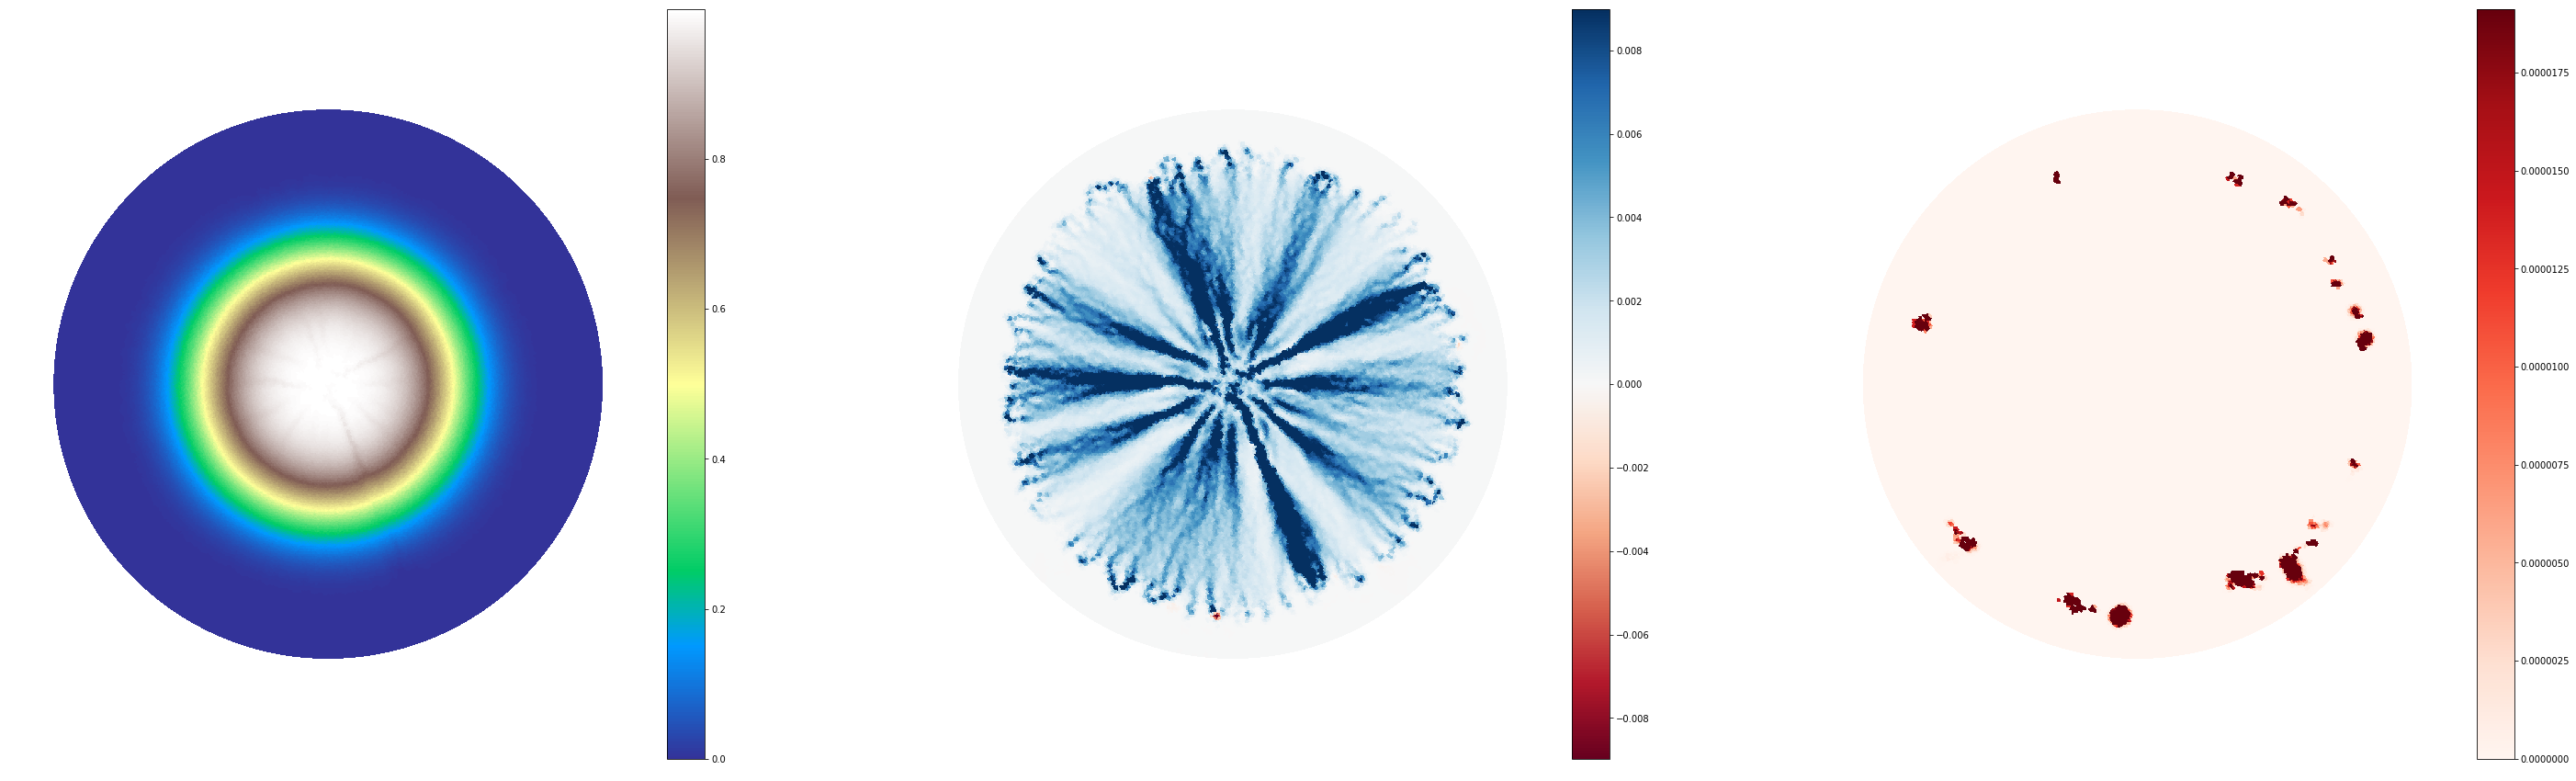

In [33]:
# Plot the stream power, erosion and deposition rates
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(50,15))
for ax in [ax1, ax2, ax3]:
    ax.axis('equal')
    ax.axis('off')


dhmax = np.abs(delta).mean() * 3.0
ermax = np.abs(erosion_deposition_rate).mean() * 3.0
    
#im1 = ax1.tripcolor(x, y, sp.tri.simplices, delta, cmap=plt.cm.RdBu, vmin=-dhmax, vmax=dhmax)    
im1 = ax1.tripcolor(x, y, sp.tri.simplices, sp.height, cmap=plt.cm.terrain)
im2 = ax2.tripcolor(x, y, sp.tri.simplices, erosion_deposition_rate, cmap='RdBu', vmin=-ermax, vmax=ermax)
im3 = ax3.tripcolor(x, y, sp.tri.simplices, deposition_rate, cmap='Reds', vmax=deposition_rate.mean()*3.0)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)
plt.show()

